In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import category_encoders as ce

def load_raw(path: str, sep: str = '|') -> pd.DataFrame:
    return pd.read_csv(path, sep=sep)

def filter_and_map_target(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['FRAUD'].isin(['Fraude', 'Descartado'])].copy()
    df['fraude_bin'] = (df['FRAUD'] == 'Fraude').astype(int)
    return df

def prepare_dates(df: pd.DataFrame) -> pd.DataFrame:
    df['FEC_DENUNCIO']  = pd.to_datetime(df['FEC_DENUNCIO'], errors='coerce')
    df['FEC_SINIESTRO'] = pd.to_datetime(df['FEC_SINIESTRO'], errors='coerce')
    df['FEC_SINIESTRO'].fillna(df['FEC_DENUNCIO'], inplace=True)
    df['lag_dias'] = (df['FEC_DENUNCIO'] - df['FEC_SINIESTRO']).dt.days
    return df

def handle_missing_and_encode(df: pd.DataFrame) -> pd.DataFrame:
    # Eliminar CANTIDAD_AUTOS
    df.drop(columns=['CANTIDAD_AUTOS'], inplace=True)
    # CANTIDAD_HIJOS
    df['CANTIDAD_HIJOS'] = df['CANTIDAD_HIJOS'].replace(999, np.nan)
    df['CANTIDAD_HIJOS'].fillna(df['CANTIDAD_HIJOS'].mode()[0], inplace=True)
    df['CANTIDAD_HIJOS'] = df['CANTIDAD_HIJOS'].astype(int)
    # ANIO_VEHICULO
    df['ANIO_VEHICULO'] = df['ANIO_VEHICULO'].fillna(df['ANIO_VEHICULO'].median()).astype(int)
    # PRODUCTO → agrupar rarezas + target encode
    df['PRODUCTO'] = df['PRODUCTO'].astype(str).fillna('Desconocido')
    freqs = df['PRODUCTO'].value_counts(normalize=True)
    rares = freqs[freqs < 0.01].index
    df['PRODUCTO_grp'] = df['PRODUCTO'].replace(rares, 'Otros')
    te_prod = ce.TargetEncoder(cols=['PRODUCTO_grp'], smoothing=0.3)
    df['PRODUCTO_te'] = te_prod.fit_transform(df[['PRODUCTO_grp']], df['fraude_bin'])
    # ESTADO_CIVIL → one-hot
    mapping_ec = {
        'Casada/o':'Casado/a','Casada':'Casado/a',
        'Divorciado':'Divorciado/a','Divorciado/a':'Divorciado/a'
    }
    df['ESTADO_CIVIL'] = df['ESTADO_CIVIL'].replace(mapping_ec).fillna('Desconocido')
    ohe_ec = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ec_arr = ohe_ec.fit_transform(df[['ESTADO_CIVIL']])
    df[ohe_ec.get_feature_names_out(['ESTADO_CIVIL'])] = ec_arr
    df.drop(columns=['ESTADO_CIVIL'], inplace=True)
    # MARCA_VEHICULO → target encode
    df['MARCA_VEHICULO'] = df['MARCA_VEHICULO'].fillna('Desconocido')
    te_marca = ce.TargetEncoder(cols=['MARCA_VEHICULO'], smoothing=0.3)
    df['MARCA_VEHICULO_te'] = te_marca.fit_transform(df[['MARCA_VEHICULO']], df['fraude_bin'])
    # PRIMA_MENSUAL_UF
    df['PRIMA_MENSUAL_UF'].fillna(df['PRIMA_MENSUAL_UF'].median(), inplace=True)
    # ROBO category
    df['ROBO'] = df['ROBO'].astype('category')
    # DEDUCIBLE quartiles + one-hot
    df['ded_q'] = pd.qcut(df['DEDUCIBLE'], 4, labels=[f'Q{i}' for i in range(1,5)])
    ohe_ded = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ded_arr = ohe_ded.fit_transform(df[['ded_q']])
    df[ohe_ded.get_feature_names_out(['ded_q'])] = ded_arr
    df['DEDUCIBLE_scaled'] = StandardScaler().fit_transform(df[['DEDUCIBLE']])
    df.drop(columns=['ded_q','DEDUCIBLE'], inplace=True)
    # CANAL_CONTRATACION one-hot
    ohe_can = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    can_arr = ohe_can.fit_transform(df[['CANAL_CONTRATACION']])
    df[ohe_can.get_feature_names_out(['CANAL_CONTRATACION'])] = can_arr
    df.drop(columns=['CANAL_CONTRATACION'], inplace=True)
    return df

def finalize_and_save(df: pd.DataFrame, raw_df: pd.DataFrame, path: str) -> None:
    """
    Selecciona las 6 features, plus claim_id y monto_fraude, y guarda.
    """
    # Unir claim_id y monto_fraude desde raw_df (mismo orden tras filter_and_map_target)
    df['CLAIM_ID']     = raw_df['CLAIM_ID'].values
    df['MONTO_FRAUDE'] = raw_df['MONTO_FRAUDE'].values
    selected = [
        'CLAIM_ID','MONTO_FRAUDE',
        'MARCA_VEHICULO_te','lag_dias','PRIMA_MENSUAL_UF',
        'PRODUCTO_te','ANIO_VEHICULO','CANTIDAD_HIJOS','fraude_bin'
    ]
    df[selected].to_csv(path, index=False)

if __name__ == '__main__':
    raw_path  = '../data/raw/dataset.csv'
    proc_path = '../data/processed/fraud_prepared_with_id.csv'

    # 1) Carga raw y filtrar
    df_raw = load_raw(raw_path)
    df_filt = filter_and_map_target(df_raw)
    df_filt = df_filt.reset_index(drop=True)

    # 2) Imprimir pesos
    print('Class weights:', compute_class_weight(
        class_weight='balanced',
        classes=np.unique(df_filt['fraude_bin']),
        y=df_filt['fraude_bin']
    ))

    # 3) Preparación
    df_dates = prepare_dates(df_filt)
    df_enc   = handle_missing_and_encode(df_dates)
    df_enc = df_enc.reset_index(drop=True)

    # 4) Finalizar y guardar con ID y monto
    finalize_and_save(df_enc, df_filt, proc_path)
    print('Data preparation completed. Saved fraud_prepared_with_id.csv')

Class weights: [ 0.51548209 16.64769231]
Data preparation completed. Saved fraud_prepared_with_id.csv


/var/folders/_1/w69g8x_57mjckhy1t8l4mkbw0000gn/T/ipykernel_24391/3560903341.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FEC_SINIESTRO'].fillna(df['FEC_DENUNCIO'], inplace=True)
/var/folders/_1/w69g8x_57mjckhy1t8l4mkbw0000gn/T/ipykernel_24391/3560903341.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setti

In [2]:
import pandas as pd
df = pd.read_csv('../data/processed/fraud_prepared_with_id.csv')
# Separamos features, target, ID y monto
X         = df.drop(columns=['CLAIM_ID','MONTO_FRAUDE','fraude_bin'])
y         = df['fraude_bin'].values
claim_ids = df['CLAIM_ID']
montos    = df['MONTO_FRAUDE']

In [3]:
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV

# 2.1 Instanciar con los mejores params
cb = CatBoostClassifier(
    iterations=200,
    auto_class_weights='Balanced',
    depth=10,
    learning_rate=0.001,
    l2_leaf_reg=10,
    bagging_temperature=1.0,
    border_count=32,
    random_seed=42,
    verbose=False
)
# 2.2 Entrenar
cb.fit(X, y)
# 2.3 Calibrar
calib_cb = CalibratedClassifierCV(cb, method='sigmoid', cv=3)
calib_cb.fit(X, y)

CalibratedClassifierCV(cv=3,
                       estimator=<catboost.core.CatBoostClassifier object at 0x125281010>)

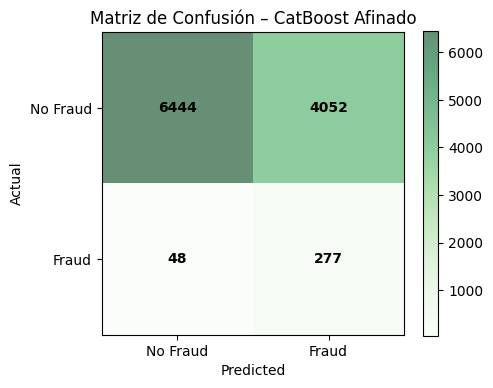

,Tasa Detección de Fraudes,Total Monto Capturado
CatBoost,0.852,"7,718,247 unidades monetarias"


,Claim ID,Fraud Score,Monto Fraude [unidades monetarias]
0,2616,0.083,"167,583"
1,19072,0.080,"18,690"
2,18479,0.075,"7,974"
3,20621,0.073,"13,955"
4,11775,0.072,"48,846"
5,22376,0.072,"31,897"
6,14082,0.072,"23,601"
7,8668,0.072,"19,424"
8,27334,0.072,0
9,16927,0.072,0


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, confusion_matrix

# Probabilidades
proba_cb = calib_cb.predict_proba(X)[:,1]

# --- Recalcular umbral y predicción al 40% ---
thr40_cb    = np.percentile(proba_cb, 60)
pred40_cb   = (proba_cb >= thr40_cb).astype(int)
recall40_cb = recall_score(y, pred40_cb)
alerts40_cb = pred40_cb.mean()
cm_cb       = confusion_matrix(y, pred40_cb)


# Matriz de confusión estilizada ---
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm_cb, cmap='Greens', interpolation='nearest', alpha=0.6)
plt.colorbar(im, ax=ax)
ax.set_xticks([0,1]); ax.set_xticklabels(['No Fraud','Fraud'])
ax.set_yticks([0,1]); ax.set_yticklabels(['No Fraud','Fraud'])
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Matriz de Confusión – CatBoost Afinado')
for (i,j), v in np.ndenumerate(cm_cb):
    ax.text(j, i, v, ha='center', va='center', fontweight='bold')
plt.tight_layout()
plt.show()

# Cálculo de monto capturado
import pandas as pd
scores = pd.DataFrame({
    'score':        proba_cb,
    'fraud':        y,
    'monto_fraude': montos
})
n40       = int(0.4 * len(scores))
top40     = scores.nlargest(n40, 'score')
monto_cap = top40.loc[top40['fraud'] == 1, 'monto_fraude'].sum()

# Construir y mostrar la tabla de resumen
metrics_df = pd.DataFrame({
    'Tasa Detección de Fraudes': [recall40_cb],
    'Total Monto Capturado':      [monto_cap]
}, index=['CatBoost'])

metrics_styled = metrics_df.style.format({
    'Tasa Detección de Fraudes': '{:.3f}',
    'Total Monto Capturado':      '{:,.0f} unidades monetarias'
}).background_gradient(subset=['Tasa Detección de Fraudes'], cmap='Greens') \
  .set_caption("Resumen de Métricas del Modelo")

display(metrics_styled)

# --- Tabla Top 10 ---
scores = pd.DataFrame({
    'Claim ID':                             claim_ids,
    'Fraud Score':                          proba_cb,
    'Monto Fraude [unidades monetarias]':   montos
})
top10 = scores.sort_values('Fraud Score', ascending=False).head(10).reset_index(drop=True)

styled = top10.style.format({
    'Fraud Score': '{:.3f}',
    'Monto Fraude [unidades monetarias]': '{:,.0f}'
}).background_gradient(subset=['Fraud Score'], cmap='Greens') \
 .set_caption("Top 10 Siniestros por Probabilidad de Fraude")

display(styled)